In [1]:
import matplotlib.image as mpimg
import math
import copy
import time
import cv2 as cv
import glob
import random
import torch
import torchvision
import numpy as np 
from torchvision import transforms, datasets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import cv2
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from skimage import io
import re
import warnings
import os
from scipy.ndimage.measurements import label
from torch.utils.data.sampler import SubsetRandomSampler
warnings.filterwarnings('ignore')

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import zipfile
import shutil
from google.colab import files
import json
import time
import pandas as pd

import keras
from keras.models import Model, Sequential, load_model
from keras.applications.resnet50 import ResNet50
from keras.layers import Input, Dense, Activation, Dropout, BatchNormalization,\
                          Conv2D, MaxPooling2D, Flatten, AveragePooling2D,\
                          GlobalAveragePooling2D, ZeroPadding2D
from keras.initializers import glorot_uniform
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop, Adam, Adamax, Nadam, SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, \
                            classification_report
import pickle

Using TensorFlow backend.


In [0]:
from shutil import rmtree
#rmtree('./Patch')
rmtree('./Outputs')
#rmtree('/content/mixed_colony_images_nogt')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
from keras import backend as K
if K.backend() == "tensorflow":
    import tensorflow as tf
    device_name = tf.test.gpu_device_name()
    if device_name == '':
        device_name = "None"
    print('Using TensorFlow version:', tf.__version__, ', GPU:', device_name)

Using TensorFlow version: 1.15.0 , GPU: /device:GPU:0


## Load the well trained model 

Replace this with most updated classifier 

In [4]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

eight_classes_id = '1w0u_EKaSG8zkMRtYkNjFd3IOnR3IpQsJ' # model_8_classes_0.8465
C1_C2_3_id = '18De1DbqyxD1JlNpue6LIUZXd73VgAN-f' # model C1 vs C2-3 vs all_other
C4_7_C5_id = '1-4e6W-yR13q3ckpgo8O9QVMTncWITHwg' # model_C4-7_vs_C5_vs_all-other
pos_vs_neg_id = '1-BxPnguFXE7PHmzKadW0AnwWO9VqTywR' # model pos-neg

files_ids_dict = {'model_eight_classes': eight_classes_id,
                  'model_C1_C2_3': C1_C2_3_id,
                  'model_C4_7_C5': C4_7_C5_id,
                  'model_pos_vs_neg': pos_vs_neg_id}

models_names_dict = {}
for model_name, file_id in files_ids_dict.items():
    downloaded = drive.CreateFile({'id': file_id})
    downloaded.GetContentFile(downloaded['title'])
    print('Downloaded content: "{}"'.format(downloaded['title']))
    models_names_dict[model_name] = downloaded['title']

print('\ncnn_models_names_dict:', str(json.dumps(models_names_dict, indent=2, default=str)))

file_id = '1npIUvxesxWQVMOr8V5enHsTYz-x7-nuE' # 'combine' model_09100
#file_id = '1aw3Bv1vXDlU_9ZTWeMTEzA44Jo3LlIzA' # 'combine' model_09203
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile(downloaded['title'])
print('\nDownloaded content: "{}"'.format(downloaded['title']))
print('\nRoot dir content: {}'.format(os.listdir()))
model_combine = downloaded['title']


eight_classes_model = load_model(models_names_dict['model_eight_classes'])
C1_C2_3_model = load_model(models_names_dict['model_C1_C2_3'])
C4_7_C5_model = load_model(models_names_dict['model_C4_7_C5'])
pos_vs_neg_model = load_model(models_names_dict['model_pos_vs_neg'])
combine_model = pickle.load(open(model_combine, 'rb'))


Downloaded content: "model_8_classes_08465.h5"
Downloaded content: "model_C1_C2-3_08983.h5"
Downloaded content: "model_C4-7_C5_083.h5"
Downloaded content: "model_pos_neg_09973.h5"

cnn_models_names_dict: {
  "model_eight_classes": "model_8_classes_08465.h5",
  "model_C1_C2_3": "model_C1_C2-3_08983.h5",
  "model_C4_7_C5": "model_C4-7_C5_083.h5",
  "model_pos_vs_neg": "model_pos_neg_09973.h5"
}

Downloaded content: "combine_model_0.9100.sav"

Root dir content: ['.config', 'model_C1_C2-3_08983.h5', 'model_pos_neg_09973.h5', 'model_8_classes_08465.h5', 'adc.json', 'drive', 'combine_model_0.9100.sav', 'model_C4-7_C5_083.h5', 'sample_data']














Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [0]:
def predict_patches(X, scaled=False):
    """
    Generates output predictions for the input 128x128 patches.
    :param X: A Numpy array (or array-like) containing the patches.
              X.shape is (N_samples,patch_width,patch_height,channels)
              patch_width,patch_height = 128,128
              channels = 3 (RGB) 
    :param scaled: Boolean. Used to indicate if the patches were already
              scaled from [0-255] to [0-1].          
    :return: predictions, class_dict
             predictions: array of shape (N_samples,) with the class indices
             classs_dict: class dictionary mapping indices to class_names
    """ 
    if not scaled: X = X.astype('float64')/255
    eight_classes_scores = eight_classes_model.predict(X)
    C1_C2_3_scores = C1_C2_3_model.predict(X)
    C4_7_C5_scores = C4_7_C5_model.predict(X)
    pos_vs_neg_scores = pos_vs_neg_model.predict(X)
    X_probs = np.hstack((eight_classes_scores,C1_C2_3_scores,C4_7_C5_scores,pos_vs_neg_scores))
    #print(X_probs)
    y_pred = combine_model.predict(X_probs)
    y_pos_neg = np.argmax(pos_vs_neg_scores, axis=1)
    y_pred[y_pos_neg==0] = 8
    class_dict = {0: "C10_pos",
                  1 :"C1_pos",
                  2: "C2-3_pos",
                  3: "C4-7_pos",
                  4: "C5_pos",
                  5: "C6_pos",
                  6: "C8_pos",
                  7: "C9_pos",
                  8: "neg"}
    return y_pred, class_dict

In [6]:
ls './mixed_colony_images/mixed_colony_images_gt/Mixed-colony_01_010.jpg'

ls: cannot access './mixed_colony_images/mixed_colony_images_gt/Mixed-colony_01_010.jpg': No such file or directory


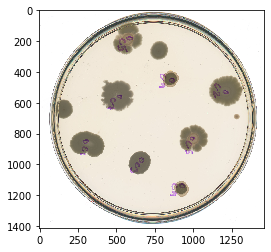

In [13]:
img=io.imread('./mixed_colony_images/mixed_colony_images_gt/Mixed-colony_01_010.jpg')
plt.imshow(img)

In [0]:
t=np.expand_dims(img,axis=0)
plt.imshow(t[0,200:328,400:528,:])
patch=t[:,500:628,400:528,:]
predict_patches(patch, scaled=False)

## Object detection on mixed colony data

In [0]:
!unzip './drive/My Drive/Capstone/mixed_colony_images.zip' 

In [0]:
!mkdir 'mixed_colony_images'

In [0]:
!mv './mixed_colony_images_gt' 'mixed_colony_images/'

## No preprocessing the data 

In [0]:
file_list=os.listdir('./mixed_colony_images/mixed_colony_images_gt')
if 'Patch' not in os.listdir('./'):
  os.mkdir('./Patch')
  for i in range(len(file_list)):
    os.mkdir('./Patch/'+file_list[i])
    os.mkdir('./Patch/'+file_list[i]+'/'+file_list[i])

In [0]:
def generate_patch(save_path,img,window,step):
  """img.shape is like (1444,1444,3)
  """
  H, W  = img.shape[0:2]
  num_boxes  = 0 
  y_start = 0
  x_start = 0
  for x_start in range(0,W-window,step):
    for y_start in range(0,H-window,step):
      img_patch = img[y_start:y_start+window,x_start:x_start+window,:]
      if img_patch.shape != (window,window,3):
        continue 
      name=str(x_start)+'_'+str(y_start)+'_'+str(window)
      io.imsave(save_path+name+'.jpg',img_patch)
  return

In [0]:
folder='./mixed_colony_images/mixed_colony_images_gt/'
for im in os.listdir(folder):
  save_path='./Patch/'+im+'/'+im+'/'
  img=io.imread(folder+im)
  window=128
  step=window//4
  generate_patch(save_path,img,window,step)

(128, 128, 3)


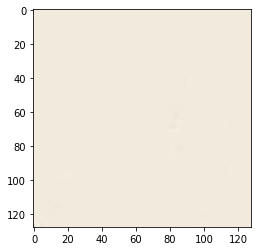

In [43]:
# read in data to the generator  
c1_pos_folder = './Patch/Mixed-colony_01_010.jpg/Mixed-colony_01_010.jpg'
img = plt.imread(c1_pos_folder + '/' + os.listdir(c1_pos_folder)[100])
plt.imshow(img)
img_size = img.shape
print(img_size)

In [0]:
def get_coordinate(s):
  l=s.split('_')
  x_start=int(l[0])
  y_start=int(l[1])
  window=int(l[2][:-4])
  return ((x_start, y_start),(window+x_start,window+y_start))


In [0]:
class_dict = {0: "C10",
                  1 :"C1",
                  2: "C2-3",
                  3: "C4-7",
                  4: "C5",
                  5: "C6",
                  6: "C8",
                  7: "C9",
                  8: "neg"}

In [0]:
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0 
    return heatmap
    
def draw_labeled_heatmap(img, labels):
    # loop over all distinctly detected patches
    for car_number in range(1, labels[1]+1):
        # get pixel indices for current car_number
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        img = cv2.rectangle(img, bbox[0], bbox[1], (255,0,255), 6)
    return img

def heatmap_generation(heat_threshold,image,boxes,savepath): 
    """image shape is like (1354, 1354, 3)
      boxes is generated from the function get_hot_bboxes()
      draw the heatmap 
    """
    # intialize heat map
    heat = np.zeros_like(image[:,:,0]).astype(np.uint16)
    # add all positive box detections to the heat map
    heat = add_heat(heat,boxes)
    # threshold the heat map
    heat_thresh = apply_threshold(np.copy(heat), heat_threshold)
    # combine the resulting heat map into continuous patches with identifier, and get number of identifications
    labels = label(heat_thresh)
    num_car_det = labels[1]
    # draw the resulting labels on the original test image
    test_img_ann = draw_labeled_heatmap(np.copy(image), labels)
    # Visualize the heat map approach
    fig, plts = plt.subplots(1, 4, figsize=(32,8))
    plts[0].imshow(heat, cmap='gray'); plts[0].axis('off');
    plts[0].set_title('Initial heat map', fontsize=25)
    plts[1].imshow(heat_thresh, cmap='gray'); plts[1].axis('off');
    plts[1].set_title('Thresholding.{}'.format(heat_threshold), fontsize=25)
    # plts[2].imshow(labels[0], cmap='gray'); plts[2].axis('off');
    # plts[2].set_title('After combining', fontsize=25)
    plts[2].imshow(test_img_ann); plts[2].axis('off');
    plts[2].set_title('class '+class_dict[target], fontsize=25)
    
    plts[3].imshow(image); plts[3].axis('off');
    plts[3].set_title('Original Image', fontsize=25)
    
    plt.savefig(savepath)
    plt.show()


In [0]:
if "Outputs" not in os.listdir('./'):
    os.mkdir('./Outputs')

In [0]:
val_batch_size=64
val_datagen = ImageDataGenerator()
for im in file_list:
  folder='./Patch/'+im+'/'
  val_generator = val_datagen.flow_from_directory(
          folder,
          target_size=(img_size[0],img_size[1]),
          batch_size=val_batch_size,
          class_mode='categorical',
          shuffle=False)
  X, y_true = next(val_generator)
  y_pred=predict_patches(X, scaled=False)[0]
  for i in range(1, len(val_generator)):
    X, y = next(val_generator)

    y_pred = np.hstack((y_pred, predict_patches(X, scaled=False)[0]))
  
  patch_list=[x.split('/')[1] for x in val_generator.filenames]
  img=io.imread('./mixed_colony_images/mixed_colony_images_gt/'+im)
  
  for target in [0,1,2,3,4,5,6,7]:
      print("Looking for "+ class_dict[target])
      boxes=[get_coordinate(name) for name in np.array(patch_list)[[y_pred==target]]]
      print(len(boxes))
      image=np.copy(img)
      for bb in boxes:
        image2=cv2.rectangle(image,bb[0],bb[1], color=(255,0,0), thickness=6) 
        #plt.imshow(image2)
      if len(boxes)!=0:
        heat_threshold=3
        save_path='./Outputs/'+im+'_'+class_dict[target]+'.jpg'
        heatmap_generation(heat_threshold,np.copy(img),boxes,save_path)
      print("\n")
  

In [0]:
#save the file in the drive 
from google.colab import files
!zip -r /Heatmap_128_new.zip ./Outputs
!mv /Heatmap_128_new.zip /content/drive/My\ Drive/Capstone/